# **E-mail spam classification**

Importing the libraries

In [18]:
import spacy
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from spacy.lang.en import English
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [3]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [4]:
nlp = spacy.load("en_core_web_sm")

In [5]:
stopwords = STOP_WORDS
print(stopwords)
print(len(stopwords))

{'whereas', 'after', 'very', 'five', 'thereupon', 'most', 'would', 'only', '’ll', 'for', 'am', 'though', 'via', 'beyond', 'ever', 'anyhow', 'their', 'less', 'someone', 'several', 'nobody', 'namely', 'under', 'thereby', 'i', 'themselves', 'perhaps', 'something', '‘ll', 'whom', 'whereby', 'above', 'those', 'used', '‘s', 'formerly', 'myself', 'toward', 'therefore', 'through', 'see', 'these', 'being', 'across', 'quite', 'ours', 'been', 'could', 'nevertheless', 'somehow', 'towards', 'which', 'much', 'had', 'part', 'from', 'up', 'seeming', 'so', 'whether', 'even', 'another', 'always', 'empty', 'still', 'least', 'cannot', 'keep', 'thence', '’re', 'last', 'together', 'latter', 'once', 'behind', 'herein', 'made', 'move', 'also', 'whose', 'her', 'well', 'full', "'s", 'ten', '’s', 'besides', 'ca', 'will', 'few', 'get', 'many', 'and', 'hence', 'who', 'nothing', 'amongst', 'beforehand', 'yourselves', 'can', 'others', 'doing', 'make', '’ve', 'whence', 'amount', 'must', 'show', 'seem', 'he', 'further

In [6]:
parser = English()

Load the datasets

In [9]:
df_spam = pd.read_csv('/content/mydrive/MyDrive/project 02 (Email spam classification with NLP)/Data set/emails.csv')
df_spam.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [10]:
df_spam.shape

(5728, 2)

Data Preprocessing

In [11]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [13]:
df_spam.spam.value_counts()

,count
spam,
0,4360
1,1368


In [14]:
# Getting information regarding the null entries in the dataset
df_spam.isnull().sum()

,0
text,0
spam,0


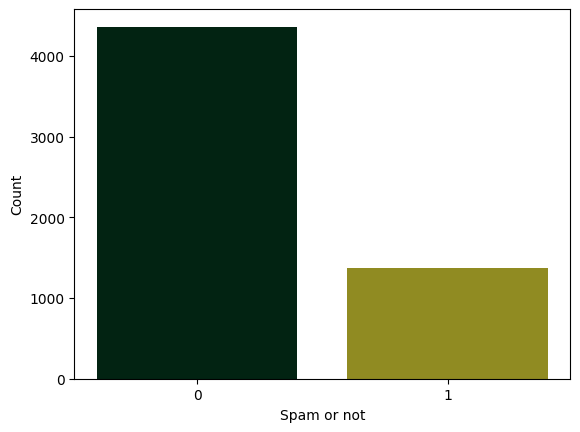

In [35]:
# Visualizing the data imbalance
plt.bar([0, 1], df_spam.spam.value_counts().sort_index().values, color=['#022312', '#908B22'])
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Spam or not')
plt.ylabel('Count')
plt.show()

Create a subset of the dataset

In [37]:
# Separate the classes
df_0 = df_spam[df_spam['spam'] == 0]
df_1 = df_spam[df_spam['spam'] == 1]

# Find the smaller class size
min_count = 1000

# Sample equal number of rows from both classes
df_0_balanced = df_0.sample(n=min_count, random_state=42)
df_1_balanced = df_1.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([df_0_balanced, df_1_balanced]).sample(frac=1, random_state=42)

# Reset index
balanced_df = balanced_df.reset_index(drop=True)

In [38]:
balanced_df.head()

,text,spam
0,Subject: click here to improve your wellbeing ...,1
1,Subject: additional e - mail addresses vince ...,0
2,Subject: veryy useful how to save on y slapst...,1
3,"Subject: credit business plan hi jeff , my r...",0
4,Subject: breathtaking image for your company n...,1


In [39]:
balanced_df.shape

(2000, 2)

In [40]:
balanced_df.spam.value_counts()

,count
spam,
1,1000
0,1000


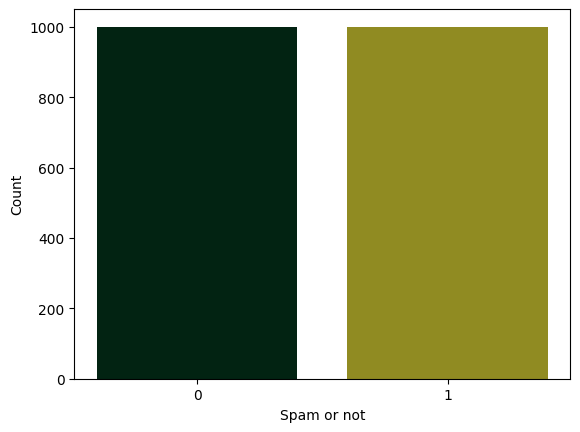

In [41]:
# Visualizing the data imbalance after the balanced process
plt.bar([0, 1], balanced_df.spam.value_counts().sort_index().values, color=['#022312', '#908B22'])
plt.xticks([0, 1], ['0', '1'])
plt.xlabel('Spam or not')
plt.ylabel('Count')
plt.show()

In [42]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [43]:
# Remove the stopwords and punctuation marks
def clean_data(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punctuation and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

Data Spliting

In [44]:
x = balanced_df['text']
y = balanced_df['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
print(x_train.shape,y_test.shape)

(1600,) (400,)


Prepare the model & Train the model

In [45]:
# Creating the model and pipeline
tfidf = TfidfVectorizer(tokenizer = clean_data)
lgr = LogisticRegression()
steps = [('tfidf',tfidf),('lgr',lgr)]
pipe = Pipeline(steps)

In [46]:
# Training the model
pipe.fit(x_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_data at 0x7c1e82482ca0>)),
                ('lgr', LogisticRegression())])

Test the model

In [47]:
y_pred = pipe.predict(x_test)

In [48]:
# Printing the classification report and the confusion matrix
print("Classification Report")
print(classification_report(y_test,y_pred))
print("\n\n")
print(confusion_matrix(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       209
           1       0.97      0.99      0.98       191

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400




[[203   6]
 [  1 190]]


In [49]:
# Model Accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9825
Precision: 0.9693877551020408
Recall: 0.9947643979057592


Testing on random news

*1 - Real News; 0 - Fake News*

In [50]:
pipe.predict(["Subject: marketpoint gas model  dear mr . braun :  as i mentioned , i have recently been reassigned here at enron . although i am  still in the enron transportation services group , i am no longer the most  appropriate contact for consideration of the altos gas model . i would  suggest you contact kim watson at 713 - 853 - 3098 or of course , vince kaminski ,  who will remain very much a part of the decision process .  regards ,  john goodpasture"])

array([0])

In [51]:
pipe.predict(["Subject: you don _ t know how to get into search engine results ?  submitting your website in search engines may increase  your online sales dramatically .  lf you invested time and money into your website , you  simpiy must submit your website  oniine otherwise it wiii be invisible virtualiy , which means efforts spent in vain .  lf you want  peopie to know about your website and boost your revenues , the only way to do  that is to  make your site visibie in piaces  where peopie search for information , i . e .  submit your  website in muitiple search engines .  submit your website online  and watch visitors stream to your e - business .  best regards ,  moshedelaney _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _"])

array([1])